In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import math
import os
import collections
import re
from datasets import load_dataset
import matplotlib.pyplot as plt
import unicodedata

In [ ]:
# Pour la reproductibilité
torch.manual_seed(16)

# Config

In [ ]:
# --- Configuration Globale ---
class Config:
    
    # Architecture
    d_model: int = 256
    n_layers: int = 4
    n_heads: int = 4
    block_size: int = 512
    rms_norm_eps: float = 1e-5
    rope_theta: float = 10000.0
    vocab_size: int = None # Sera défini après le chargement des données

    # MoE
    num_local_experts: int = 4
    num_experts_per_tok: int = 2
    intermediate_size_expert_factor: int = 2 # Multiplicateur pour d_model
    intermediate_size_shared_factor: int = 2 # Multiplicateur pour d_model

    # Entraînement
    learning_rate: float = 5e-4
    batch_size: int = 2
    epochs: int = 12000
    eval_interval: int = 300

    # Dérivé / Calculé
    d_k: int = d_model // n_heads
    intermediate_size_expert: int = d_model * intermediate_size_expert_factor
    intermediate_size_shared: int = d_model * intermediate_size_shared_factor

    # Device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def __post_init__(self):
        """Vérifications post-initialisation."""
        assert self.d_model % self.n_heads == 0, "d_model doit être divisible par n_heads"
        self.d_k = self.d_model // self.n_heads
        self.intermediate_size_expert = self.d_model * self.intermediate_size_expert_factor
        self.intermediate_size_shared = self.d_model * self.intermediate_size_shared_factor

    def print_config(self):
        """Affiche la configuration."""
        print("--- Configuration du Modèle ---")
        for key, value in self.__dict__.items():
             # N'affiche pas les méthodes ou les attributs privés/spéciaux
            if not key.startswith('_') and not callable(value):
                print(f"{key}: {value}")
        print("-----------------------------")

# Instancier la configuration
config = Config()
# Initialiser les valeurs calculées
config.__post_init__()

In [ ]:
# --- Tokenizer ---
class SimpleCharTokenizer:
    def __init__(self, corpus):
        self.chars = sorted(list(set(corpus)))
        self.vocab_size = len(self.chars)
        self.char_to_int = {ch: i for i, ch in enumerate(self.chars)}
        self.int_to_char = {i: ch for i, ch in enumerate(self.chars)}
        print(f"Tokenizer créé avec une taille de vocabulaire de: {self.vocab_size}")
        # print(f"Vocabulaire: {''.join(self.chars)}")

    def encode(self, text):
        return [self.char_to_int[ch] for ch in text if ch in self.char_to_int]

    def decode(self, ids):
        return ''.join([self.int_to_char.get(id_val, '[UNK]') for id_val in ids])

In [ ]:
# --- Fonctions Utilitaires ---
def load_and_prepare_data(config):
    print("Chargement des données...")

    # Charger le dataset Wikitext en français
    wikitext_fr = load_dataset("asi/wikitext_fr", split="train", trust_remote_code=True)
    corpus_raw_vocab = ' '.join(wikitext_fr['paragraph'])
    print(f"Corpus brut chargé (longueur: {len(corpus_raw_vocab)} caractères).")

    # Créer le tokenizer
    tokenizer = SimpleCharTokenizer(corpus_raw_vocab)
    config.vocab_size = tokenizer.vocab_size # Mettre à jour la config
    
    wikitext_fr = load_dataset("asi/wikitext_fr", split="train", trust_remote_code=True)
    dataset  = wikitext_fr['paragraph'][:5000] # réduire la taille pour l'entrainement

    block_size = config.block_size

    # Créer les séquences d'entraînement x et y
    all_x = []
    all_y = []
    all_attention_masks = []

    for idx, item in enumerate(dataset):
        paragraph = item

        paragraph = unicodedata.normalize('NFD', paragraph).encode('ascii', 'ignore').decode('utf-8')

        encoded_sequence = tokenizer.encode(paragraph)
        num_tokens = len(encoded_sequence)

        if num_tokens > block_size:
            # Créer des séquences chevauchantes
            for i in range(num_tokens - block_size):
                x_chunk = encoded_sequence[i : i + block_size]
                y_chunk = encoded_sequence[i + 1 : i + block_size + 1]
                attention_mask = [1] * block_size  # Masque d'attention : 1 pour les tokens réels
                all_x.append(x_chunk)
                all_y.append(y_chunk)
                all_attention_masks.append(attention_mask)
        elif num_tokens <= block_size:
            # Ajouter du padding si la séquence est trop courte
            padding_length = block_size - num_tokens
            x_padded = encoded_sequence + [0] * padding_length  # Pad à droite avec des zéros
            y_padded = encoded_sequence[1:] + [0] * (padding_length + 1) # decalage de 1 et padding
            x_padded = x_padded[:block_size]
            y_padded = y_padded[:block_size]
            attention_mask = [1] * num_tokens + [0] * padding_length  # 1 pour les tokens réels, 0 pour le padding
            all_x.append(x_padded)
            all_y.append(y_padded)
            all_attention_masks.append(attention_mask)

    if not all_x:
        raise ValueError("Aucune séquence d'entraînement n'a pu être créée. Vérifiez la taille du corpus et la taille de bloc.")
    
    train_x = torch.tensor(all_x, dtype=torch.long)
    train_y = torch.tensor(all_y, dtype=torch.long)
    attention_mask = torch.tensor(all_attention_masks, dtype=torch.long)
    
    num_sequences_available = train_x.shape[0]
    print(f"{num_sequences_available} paires de séquences input/target créées.")
    print(f"Shape de train_x: {train_x.shape}")
    print(f"Shape de train_y: {train_y.shape}")
    print(f"Shape de attention_mask: {attention_mask.shape}") #afficher la shape du mask

    # Ajuster la taille du batch si nécessaire
    if num_sequences_available < config.batch_size:
        print(f"Attention : Nombre de séquences ({num_sequences_available}) inférieur à la taille du batch ({config.batch_size}). Ajustement de la taille du batch.")
        config.batch_size = num_sequences_available
        
    return train_x, train_y, attention_mask, tokenizer

def get_batch(data_x, data_y, attention_mask, batch_size, device):
    num_sequences = data_x.shape[0]
    indices = torch.randint(0, num_sequences, (batch_size,))
    xb = data_x[indices].to(device)
    yb = data_y[indices].to(device)
    attention_mask_batch = attention_mask[indices].to(device) # Récupérer aussi le masque d'attention pour le batch
    return xb, yb, attention_mask_batch

# Modèle

In [ ]:
# --- Composants du Modèle ---

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        # Le gain (gamma) est un paramètre apprenable
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        # x: (..., dim)
        # rsqrt: 1 / sqrt(x)
        # + eps pour la stabilité numérique
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        # Applique la normalisation puis multiplie par le gain apprenable
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

class RotaryPositionalEmbedding(nn.Module):
    def __init__(self, dim: int, seq_len: int, theta: float = 10000.0, device: str = 'cpu'):
        super().__init__()
        self.dim = dim
        self.seq_len = seq_len
        self.theta = theta
        self.device = device
        self.freqs_cis = self.precompute_freqs_cis(dim, seq_len, theta).to(device)

    def precompute_freqs_cis(self, dim: int, end: int, theta: float = 10000.0):
        # Calcule les fréquences inverses: 1.0 / (theta ** (2k / dim)) pour k = 0, 1, ..., dim/2 - 1
        freqs = 1.0 / (theta ** (torch.arange(0, dim, 2, dtype=torch.float)[: (dim // 2)] / dim))
        # Crée les positions de 0 à end-1
        t = torch.arange(end, dtype=torch.float)
        # Calcule les angles: position * fréquence_inverse
        freqs = torch.outer(t, freqs) # Shape (end, dim / 2)
        # Convertit en nombres complexes: cos(angle) + i*sin(angle)
        freqs_cis = torch.polar(torch.ones_like(freqs), freqs) # Shape (end, dim / 2)
        return freqs_cis

    def apply_rotary_emb(self, x: torch.Tensor, freqs_cis: torch.Tensor):
        # x: (B, T, H, Dk) ou (B, H, T, Dk) - on suppose (..., T, D) où D=dim
        # freqs_cis: (T, Dk/2)
        # Sépare x en parties réelles et imaginaires virtuelles
        # x_ -> (..., T, Dk/2, 2)
        x_ = x.float().reshape(*x.shape[:-1], -1, 2)
        # Convertit en complexe: (..., T, Dk/2)
        x_complex = torch.view_as_complex(x_)
        # Adapte freqs_cis pour le broadcasting: (1, T, 1, Dk/2) ou (T, Dk/2) -> (1, T, 1, Dk/2)
        # On suppose que freqs_cis est déjà (T, Dk/2)
        freqs_cis = freqs_cis.unsqueeze(0).unsqueeze(2) # (1, T, 1, Dk/2)
        # Applique la rotation complexe: x * exp(i*theta)
        x_rotated = x_complex * freqs_cis # Broadcasting s'applique
        # Reconvertit en réel: (..., T, Dk/2, 2)
        x_out_real = torch.view_as_real(x_rotated)
        # Recombine: (..., T, Dk)
        x_out = x_out_real.flatten(3)
        return x_out.type_as(x)

    def forward(self, q: torch.Tensor, k: torch.Tensor):
        # q, k: (B, T, H, Dk) ou (B, H, T, Dk) - on suppose (B, T, H, Dk)
        seq_len = q.shape[1] # T
        # Récupère les freqs précalculées pour la longueur de séquence actuelle
        current_freqs_cis = self.freqs_cis[:seq_len].to(q.device) # (T, Dk/2)
        # Applique RoPE
        q_out = self.apply_rotary_emb(q, current_freqs_cis)
        k_out = self.apply_rotary_emb(k, current_freqs_cis)
        return q_out, k_out

class Attention(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.n_heads = config.n_heads
        self.d_model = config.d_model
        self.d_k = config.d_k
        self.head_dim = self.d_k # Alias

        # Couches linéaires pour Q, K, V et la sortie
        self.qkv_proj = nn.Linear(config.d_model, 3 * config.d_model, bias=False)
        self.o_proj = nn.Linear(config.d_model, config.d_model, bias=False)

        # RoPE (sera initialisé avec la bonne longueur de séquence plus tard si nécessaire)
        # Note: RoPE est souvent appliqué après la projection QKV et le reshape des têtes
        # Nous allons instancier RoPE ici mais l'appliquer dans le forward
        self.rope = RotaryPositionalEmbedding(
            dim=self.head_dim,
            seq_len=config.block_size, # Longueur max
            theta=config.rope_theta,
            device=config.device
        )

        # Masque causal précalculé (pour ne pas le recréer à chaque fois)
        # Shape: (1, 1, block_size, block_size)
        self.register_buffer("causal_mask", torch.tril(torch.ones(config.block_size, config.block_size, dtype=torch.bool)).view(1, 1, config.block_size, config.block_size))


    def forward(self, x: torch.Tensor):
        B, T, C = x.shape # Batch, Sequence Length, Embedding Dim (d_model)

        # 1. Projections Q, K, V
        qkv = self.qkv_proj(x) # (B, T, 3*C)

        # 2. Séparer Q, K, V et les têtes
        # (B, T, 3*C) -> (B, T, 3, H, Dk) -> 3 x (B, T, H, Dk)
        qkv = qkv.view(B, T, 3, self.n_heads, self.head_dim)
        q, k, v = qkv.chunk(3, dim=2) # Sépare sur la dimension 3 (qui a taille 3)
        q = q.squeeze(2) # (B, T, H, Dk)
        k = k.squeeze(2) # (B, T, H, Dk)
        v = v.squeeze(2) # (B, T, H, Dk)

        # 3. Appliquer RoPE
        q_rope, k_rope = self.rope(q, k) # Applique RoPE sur (B, T, H, Dk)

        # 4. Transposer pour le calcul de l'attention: (B, H, T, Dk)
        q_rope = q_rope.transpose(1, 2)
        k_rope = k_rope.transpose(1, 2)
        v = v.transpose(1, 2)

        # 5. Calcul des scores d'attention (Scaled Dot-Product)
        # (B, H, T, Dk) @ (B, H, Dk, T) -> (B, H, T, T)
        scores = (q_rope @ k_rope.transpose(-2, -1)) * (self.head_dim ** -0.5)

        # 6. Appliquer le masque causal
        # Le masque causal a shape (1, 1, T_max, T_max)
        # On prend la partie correspondante à la longueur T actuelle
        mask = self.causal_mask[:, :, :T, :T]
        scores = scores.masked_fill(mask == 0, float('-inf'))

        # 7. Appliquer Softmax
        attn_weights = F.softmax(scores, dim=-1) # (B, H, T, T)
        # Gérer les NaN potentiels (si une ligne est entièrement -inf)
        attn_weights = torch.nan_to_num(attn_weights)

        # 8. Appliquer les poids d'attention à V
        # (B, H, T, T) @ (B, H, T, Dk) -> (B, H, T, Dk)
        attn_output = attn_weights @ v

        # 9. Concaténer les têtes
        # (B, H, T, Dk) -> (B, T, H, Dk) -> (B, T, C)
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, T, C)

        # 10. Projection de sortie
        output = self.o_proj(attn_output)
        return output

class ExpertMLP(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        hidden_dim = config.intermediate_size_expert
        # Combine les projections Gate et Up pour l'efficacité (comme dans Llama)
        self.gate_up_proj = nn.Linear(config.d_model, 2 * hidden_dim, bias=False)
        self.down_proj = nn.Linear(hidden_dim, config.d_model, bias=False)
        self.act_fn = nn.SiLU() # SwiGLU implicite

    def forward(self, x):
        # x: (..., d_model)
        gate_up = self.gate_up_proj(x) # (..., 2 * hidden_dim)
        gate, up = gate_up.chunk(2, dim=-1) # (..., hidden_dim)
        fused_activation = self.act_fn(gate) * up # (..., hidden_dim)
        output = self.down_proj(fused_activation) # (..., d_model)
        return output

class MoE(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.num_experts = config.num_local_experts
        self.num_experts_per_tok = config.num_experts_per_tok
        self.d_model = config.d_model

        # La couche de routage (gate)
        self.gate = nn.Linear(config.d_model, self.num_experts, bias=False)

        # Les experts eux-mêmes
        self.experts = nn.ModuleList([ExpertMLP(config) for _ in range(self.num_experts)])

    def forward(self, x: torch.Tensor):
        B, T, C = x.shape # Batch, Sequence Length, Dim

        # 1. Obtenir les logits du routeur
        # x: (B, T, C) -> router_logits: (B, T, num_experts)
        router_logits = self.gate(x)

        # 2. Sélectionner les Top-K experts et calculer les poids de routage
        # routing_weights: (B, T, k), selected_experts: (B, T, k)
        routing_weights, selected_experts = torch.topk(
            router_logits, self.num_experts_per_tok, dim=-1
        )
        # Appliquer Softmax (ou Sigmoid comme dans le code original) sur les poids des k experts sélectionnés
        # Le code original utilise Sigmoid, ce qui ne garantit pas que la somme soit 1.
        # Softmax semble plus standard pour pondérer les sorties. Utilisons Softmax ici.
        routing_weights = F.softmax(routing_weights, dim=-1, dtype=torch.float).to(x.dtype)
        # Si on veut Sigmoid comme l'original:
        # routing_weights = torch.sigmoid(routing_weights)

        # 3. Préparer pour le calcul parallèle des experts
        # Aplatir B et T pour traiter chaque token indépendamment
        x_flat = x.view(-1, C) # (B*T, C)
        routing_weights_flat = routing_weights.view(-1, self.num_experts_per_tok) # (B*T, k)
        selected_experts_flat = selected_experts.view(-1, self.num_experts_per_tok) # (B*T, k)

        # Initialiser le tenseur de sortie final (même taille que x_flat)
        final_output_flat = torch.zeros_like(x_flat)

        # Obtenir les indices des tokens (0 à B*T - 1)
        token_indices = torch.arange(B * T, device=x.device)

        # 4. Itérer sur les experts et calculer les sorties
        # C'est l'approche la plus simple, mais peut être inefficace.
        # L'approche du code original avec scatter_add est plus performante.
        # Répliquons l'approche scatter_add :

        # Créer un index plat pour les tokens et les experts sélectionnés
        # token_idx_expanded: (B*T*k) - Répète chaque index de token k fois
        token_idx_expanded = token_indices.repeat_interleave(self.num_experts_per_tok)
        # expert_idx_flat: (B*T*k) - Les indices des experts sélectionnés pour chaque token*expert
        expert_idx_flat = selected_experts_flat.view(-1)
        # routing_weights_flat_expanded: (B*T*k) - Les poids associés
        routing_weights_flat_expanded = routing_weights_flat.view(-1)

        # Créer un batch pour chaque expert
        # expert_inputs: (B*T*k, C) - Les inputs x_flat dupliqués pour chaque expert sélectionné
        expert_inputs = x_flat[token_idx_expanded]

        # Calculer les sorties des experts de manière batchée (si possible, sinon itérer)
        # Ici, nous allons utiliser une boucle pour la clarté, mais une implémentation
        # optimisée utiliserait des opérations batchées ou scatter/gather.
        expert_outputs_list = []
        for i in range(self.num_experts):
            # Trouver les indices des tokens qui ont sélectionné cet expert
            mask = (expert_idx_flat == i)
            if mask.any():
                # Sélectionner les inputs et les poids pour cet expert
                current_inputs = expert_inputs[mask] # (N_i, C) où N_i est le nb de tokens routés vers l'expert i
                # Calculer la sortie de l'expert
                current_outputs = self.experts[i](current_inputs) # (N_i, C)
                # Pondérer par les poids de routage correspondants
                current_weights = routing_weights_flat_expanded[mask].unsqueeze(1) # (N_i, 1)
                weighted_outputs = current_outputs * current_weights # (N_i, C)

                # Utiliser scatter_add_ pour ajouter les sorties pondérées aux bonnes positions
                # Indices originaux des tokens qui ont utilisé cet expert
                original_token_indices = token_idx_expanded[mask]
                final_output_flat.scatter_add_(0, original_token_indices.unsqueeze(1).expand(-1, C), weighted_outputs)

        # 5. Remettre en forme la sortie
        # final_output_flat: (B*T, C) -> (B, T, C)
        final_output = final_output_flat.view(B, T, C)

        return final_output

class SharedMLP(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        hidden_dim = config.intermediate_size_shared
        # Structure similaire à ExpertMLP mais avec des dimensions potentiellement différentes
        self.gate_proj = nn.Linear(config.d_model, hidden_dim, bias=False)
        self.up_proj = nn.Linear(config.d_model, hidden_dim, bias=False)
        self.down_proj = nn.Linear(hidden_dim, config.d_model, bias=False)
        self.act_fn = nn.SiLU()

    def forward(self, x):
        gate = self.gate_proj(x)
        up = self.up_proj(x)
        fused_activation = self.act_fn(gate) * up
        output = self.down_proj(fused_activation)
        return output

class TransformerBlock(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.n_heads = config.n_heads
        self.d_model = config.d_model

        # Normalisation avant l'attention
        self.input_layernorm = RMSNorm(config.d_model, eps=config.rms_norm_eps)
        # Module d'attention
        self.self_attn = Attention(config)
        # Normalisation avant le MoE/MLP
        self.post_attention_layernorm = RMSNorm(config.d_model, eps=config.rms_norm_eps)
        # Mixture of Experts
        self.moe = MoE(config)
        # MLP Partagé
        self.shared_mlp = SharedMLP(config)

    def forward(self, x: torch.Tensor):
        # Connexion résiduelle 1 (autour de l'attention)
        residual = x
        h = self.input_layernorm(x)
        attn_output = self.self_attn(h)
        h = residual + attn_output

        # Connexion résiduelle 2 (autour du MoE et MLP partagé)
        residual = h
        h_norm = self.post_attention_layernorm(h)
        # Calculer les sorties du MoE et du MLP partagé
        moe_output = self.moe(h_norm)
        shared_output = self.shared_mlp(h_norm)
        # Combiner les sorties (addition simple comme dans le papier Llama 3/4)
        h = residual + moe_output + shared_output

        return h

# --- Modèle Llama Complet ---

class LlamaMoEModel(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.config = config

        # Embedding des tokens
        self.tok_embeddings = nn.Embedding(config.vocab_size, config.d_model)

        # Blocs Transformer
        self.layers = nn.ModuleList([TransformerBlock(config) for _ in range(config.n_layers)])

        # Normalisation finale
        self.norm = RMSNorm(config.d_model, eps=config.rms_norm_eps)

        # Tête de classification (prédit le prochain token)
        # Note: Parfois, les poids de l'embedding sont liés (partagés) avec cette couche
        self.output = nn.Linear(config.d_model, config.vocab_size, bias=False)

        # Initialisation des poids (optionnel mais recommandé)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            # Initialisation standard pour les transformeurs
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, tokens: torch.Tensor):
        B, T = tokens.shape
        # 1. Obtenir les embeddings des tokens
        h = self.tok_embeddings(tokens) # (B, T, C)

        # 2. Passer à travers les blocs Transformer
        for layer in self.layers:
            h = layer(h)

        # 3. Normalisation finale
        h = self.norm(h)

        # 4. Calculer les logits de sortie
        logits = self.output(h) # (B, T, VocabSize)

        return logits

    def generate(self, tokenizer, prompt: str, max_new_tokens: int, block_size: int, device: str):
        self.eval() # Mettre le modèle en mode évaluation
        # Encoder l'amorce
        prompt_ids = tokenizer.encode(prompt)
        context = torch.tensor([prompt_ids], dtype=torch.long, device=device)

        generated_ids = []

        print(f"Génération à partir de : '{prompt}'")
        with torch.no_grad(): # Pas besoin de calculer les gradients
            for _ in range(max_new_tokens):
                # S'assurer que le contexte ne dépasse pas block_size
                context_cond = context[:, -block_size:]
                # Obtenir les logits du modèle
                logits = self(context_cond) # (B, T, VocabSize)
                # Prendre les logits du dernier token seulement
                logits_last = logits[:, -1, :] # (B, VocabSize)
                # Appliquer softmax pour obtenir les probabilités
                probs = F.softmax(logits_last, dim=-1) # (B, VocabSize)
                # Échantillonner le prochain token basé sur les probabilités
                next_token = torch.multinomial(probs, num_samples=1) # (B, 1)
                # Ajouter le token généré à la séquence
                context = torch.cat((context, next_token), dim=1)
                generated_ids.append(next_token.item())
                # Afficher le caractère généré (optionnel)
                # print(tokenizer.decode([next_token.item()]), end='', flush=True)


        print("\n--- Génération terminée ---")
        self.train() # Remettre en mode entraînement par défaut
        return tokenizer.decode(prompt_ids + generated_ids)

# Train / Test

In [ ]:
# --- Fonctions d'Entraînement et de Sauvegarde ---
def train_model(model, train_x, train_y, attention_mask, config, optimizer, criterion):

    print(f"\n--- Démarrage de l'entraînement pour {config.epochs} époques ---")
    losses = []
    model.train()

    for epoch in range(config.epochs):
        xb, yb, attention_mask_batch = get_batch(train_x, train_y, attention_mask, config.batch_size, config.device)
        logits = model(xb)

        B_loss, T_loss, V_loss = logits.shape
        logits_for_loss = logits.view(B_loss * T_loss, V_loss)
        targets_for_loss = yb.view(B_loss * T_loss)
        # Appliquer le masque d'attention pour ne considérer que les tokens non-padding dans le calcul de la perte.
        loss = criterion(logits_for_loss, targets_for_loss)
        loss = (loss * attention_mask_batch.view(-1)).sum() / attention_mask_batch.sum() #IMPORTANT

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current_loss = loss.item()
        losses.append(current_loss)
        if epoch % config.eval_interval == 0 or epoch == config.epochs - 1:
            print(f"  Époque {epoch+1}/{config.epochs}, Perte: {current_loss:.4f}")

    print("--- Entraînement terminé ---")

    # Afficher le graphique des pertes
    try:
        plt.figure(figsize=(10, 4))
        plt.plot(losses)
        plt.title("Perte d'entraînement au fil des époques")
        plt.xlabel("Époque")
        plt.ylabel("Perte")
        plt.grid(True)
        plt.show()
    except ImportError:
        print("Matplotlib non trouvé, graphique des pertes ignoré.")
    except Exception as e:
        print(f"Impossible d'afficher le graphique des pertes: {e}")

    return losses


def save_model_checkpoint(model, tokenizer, config, optimizer, file_path='llama_moe_model_checkpoint.pt'):
    """Sauvegarde l'état du modèle, du tokenizer et de l'optimiseur."""
    checkpoint = {
        'config': config.__dict__, # Sauvegarder la configuration
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'tokenizer': { # Sauvegarder les mappings du tokenizer
            'char_to_int': tokenizer.char_to_int,
            'int_to_char': tokenizer.int_to_char,
            'chars': tokenizer.chars,
            'vocab_size': tokenizer.vocab_size
        }
    }
    # Créer le répertoire si nécessaire
    save_dir = os.path.dirname(file_path)
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)

    torch.save(checkpoint, file_path)
    print(f"Checkpoint du modèle sauvegardé dans '{file_path}'")

def load_model_from_checkpoint(file_path='llama_moe_model_checkpoint.pt'):
    """Charge un modèle à partir d'un checkpoint."""
    if not os.path.exists(file_path):
        print(f"Fichier de checkpoint '{file_path}' non trouvé.")
        return None, None, None, None

    checkpoint = torch.load(file_path, map_location=lambda storage, loc: storage) # Charger sur CPU par défaut

    # Recréer la configuration
    loaded_config_dict = checkpoint['config']
    loaded_config = Config() # Créer une instance vide
    # Mettre à jour avec les valeurs chargées
    for key, value in loaded_config_dict.items():
         if hasattr(loaded_config, key):
              setattr(loaded_config, key, value)
    # Recalculer les valeurs dérivées
    loaded_config.__post_init__()
    # Définir le device actuel
    loaded_config.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Recréer le tokenizer
    tokenizer_data = checkpoint['tokenizer']
    tokenizer = SimpleCharTokenizer("") # Initialiser avec un corpus vide
    tokenizer.char_to_int = tokenizer_data['char_to_int']
    tokenizer.int_to_char = tokenizer_data['int_to_char']
    tokenizer.chars = tokenizer_data['chars']
    tokenizer.vocab_size = tokenizer_data['vocab_size']
    # Mettre à jour la taille du vocabulaire dans la config chargée
    loaded_config.vocab_size = tokenizer.vocab_size

    # Recréer le modèle
    model = LlamaMoEModel(loaded_config)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(loaded_config.device) # Déplacer vers le bon device

    # Recréer l'optimiseur (optionnel, utile si on reprend l'entraînement)
    optimizer = optim.AdamW(model.parameters(), lr=loaded_config.learning_rate)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print(f"Modèle chargé depuis '{file_path}' sur le device '{loaded_config.device}'")
    return model, tokenizer, loaded_config, optimizer

Utilisation du device: cuda
--- Configuration du Modèle ---
d_k: 64
intermediate_size_expert: 512
intermediate_size_shared: 512
-----------------------------
Chargement des données...
Corpus brut chargé (longueur: 147641326 caractères).
Tokenizer créé avec une taille de vocabulaire de: 1787
727086 paires de séquences input/target créées.
Shape de train_x: torch.Size([727086, 512])
Shape de train_y: torch.Size([727086, 512])
Shape de attention_mask: torch.Size([727086, 512])

Modèle initialisé sur cuda
Nombre total de paramètres entraînables: 9,834,240
Optimiseur: AdamW, Fonction de perte: CrossEntropyLoss

--- Démarrage de l'entraînement pour 12000 époques ---
  Époque 1/12000, Perte: 7.5616
  Époque 301/12000, Perte: 2.2396
  Époque 601/12000, Perte: 1.8567
  Époque 901/12000, Perte: 1.5500
  Époque 1201/12000, Perte: 1.7405
  Époque 1501/12000, Perte: 1.5614
  Époque 1801/12000, Perte: 1.3123
  Époque 2101/12000, Perte: 1.5364
  Époque 2401/12000, Perte: 1.4552
  Époque 2701/12000, P

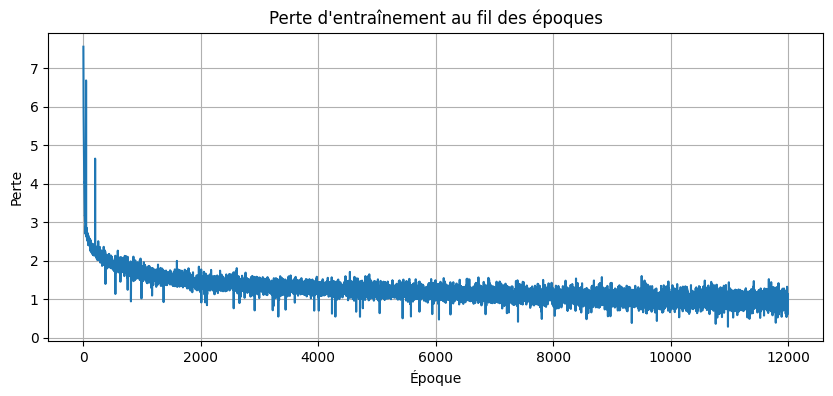


--- Génération de Texte ---
Génération à partir de : 'Le service '

--- Génération terminée ---

Texte Généré:
Le service obtient devint tant dans l'installation de mixer la chanson. Le tribunal special continue egalement Anne. Soleure prend situe respectoire de techniques connaissant le Grand ou Saint-Gall jusqu'a mais 

--- Sauvegarde du Modèle ---
Checkpoint du modèle sauvegardé dans 'saved_models_restructured/llama_moe_model_final.pt'


In [ ]:
if __name__ == "__main__":
    print(f"Utilisation du device: {config.device}")
    config.print_config()

    # 1. Charger et préparer les données
    try:
        train_x, train_y, attention_mask, tokenizer = load_and_prepare_data(config)
    except ValueError as e:
        print(f"Erreur lors de la préparation des données: {e}")
        exit() # Arrêter si les données ne peuvent pas être préparées

    # Mettre à jour la config avec la taille réelle du vocabulaire
    if config.vocab_size is None:
         config.vocab_size = tokenizer.vocab_size
         print(f"Taille du vocabulaire mise à jour dans la config: {config.vocab_size}")


    # 2. Initialiser le modèle
    model = LlamaMoEModel(config).to(config.device)
    print(f"\nModèle initialisé sur {config.device}")
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Nombre total de paramètres entraînables: {total_params:,}")

    # 3. Définir l'optimiseur et la fonction de perte
    optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)
    criterion = nn.CrossEntropyLoss()
    print(f"Optimiseur: {type(optimizer).__name__}, Fonction de perte: {type(criterion).__name__}")

    # 4. Entraîner le modèle
    train_model(model, train_x, train_y, attention_mask, config, optimizer, criterion)

    # 5. Générer du texte
    print("\n--- Génération de Texte ---")
    prompt = "Le service "
    generated_text = model.generate(
        tokenizer=tokenizer,
        prompt=prompt,
        max_new_tokens=200,
        block_size=config.block_size,
        device=config.device
    )
    print("\nTexte Généré:")
    print(generated_text)

    # 6. Sauvegarder le modèle
    print("\n--- Sauvegarde du Modèle ---")
    save_dir = 'saved_models_restructured'
    save_path = os.path.join(save_dir, 'llama_moe_model_final.pt')
    save_model_checkpoint(model, tokenizer, config, optimizer, file_path=save_path)

In [ ]:
# 7. Charger et tester le modèle sauvegardé
print("\n--- Test du Chargement du Modèle ---")
loaded_model, loaded_tokenizer, loaded_config, _ = load_model_from_checkpoint(file_path=save_path)

if loaded_model and loaded_tokenizer:
    print("Modèle chargé avec succès. Nouvelle génération de test:")
    test_prompt = "Longtemps je me suis couché de bonne heure."
    test_generated_text = loaded_model.generate(
        tokenizer=loaded_tokenizer,
        prompt=test_prompt,
        max_new_tokens=50,
        block_size=loaded_config.block_size, # Utiliser la config chargée
        device=loaded_config.device
    )
    print("\nTexte Généré (après chargement):")
    print(test_generated_text)
else:
    print("Échec du chargement du modèle.")
    
print("\n--- Script Terminé ---")


--- Test du Chargement du Modèle ---
Tokenizer créé avec une taille de vocabulaire de: 0


/tmp/ipykernel_31/2988435836.py:651: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path, map_location=lambda storage, loc: storage) # Charger su

Modèle chargé depuis 'saved_models_restructured/llama_moe_model_final.pt' sur le device 'cuda'
Modèle chargé avec succès. Nouvelle génération de test:
Génération à partir de : 'Bonjour '

--- Génération terminée ---

Texte Généré (après chargement):
Bonjour role en 1493 et elle n'etait pas de faible indusgr

--- Script Terminé ---
